# 1 Image Processing<a id='1_processing'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Image Processing](#1_processing)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Imports](#1.3_Imports)
  * [1.4 Extract Images](#1.4_extract)
  * [1.5 Augmentation](#1.5_Augmentation)
  * [1.6 Display Example Images](#1.6_examples)  

## 1.2 Introduction<a id='1.2_Introduction'></a>

This is the beginning of a project to train a deep neural network to classify oak leaves and maple leaves. The data for the model are original images taken by cell phone video camera. Images are extracted from the videos. The images are further processed -- three augmentations for each image -- by making black and white, rotating, and flipping.

The final images are stored in separate directories (maple and oak) for later model training and testing.

## 1.3 Imports<a id='1.3_Imports'></a>

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import skimage

from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

from PIL import Image

## 1.4 Extract Images<a id='1.4_extract'></a>

The function extract_frames takes video input and converts it to images in jpg format. 

In [2]:
# credit to
# Hayden Faulkner
# https://medium.com/@haydenfaulkner/extracting-frames-fast-from-a-video-using-opencv-and-python-73b9b7dc9661

def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    
    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir) 

    video_dir, video_filename = os.path.split(video_path)  # split into path and filename

    assert os.path.exists(video_path)  # for debugging

    capture = cv2.VideoCapture(video_path)  # open video with OpenCV

    if start < 0:  # if start isn't specified, make half a second in
        start = 15
    if end < 0:  # if end isn't specified, make the very end 
        end = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    capture.set(1, start)  # set the starting frame of the capture
    frame = start  # frame keeps track with video. initialize to start.
    while_safety = 0  # a safety counter to avoid an infinite while loop
    saved_count = 0  # a count of how many frames saved

    while frame < end:  # loop through the frames until the end

        _, image = capture.read()  # read an image from the capture

        if while_safety > 500:  # break out if safety exceeds 500 (see below)
            break

        # sometimes OpenCV reads None's during a video, in which case we want to skip
        if image is None:  # the image we read is None, don't save
            while_safety += 1  # add 1 to safety count
            continue  # skip to next frame

        if frame % every == 0:  # extract every nth frame
            while_safety = 0  # frame is read, reset the safety count
            name_root = video_filename.split('.')[0] # take name of video from filename
            save_path = os.path.join(frames_dir, name_root + '_{}.jpg'.format(frame))   # name frame with video name and frame number
             
            if not os.path.exists(save_path) or overwrite:  # if file doesn't exist or overwrite allowed
                cv2.imwrite(save_path, image)  # save the extracted frame
                saved_count += 1  # increment our counter by one

        frame += 1  # increment frame count

    capture.release()  # close the capture

    return saved_count  # return the count of the images saved

In [ ]:
# ignore for now

#from concurrent.futures import ProcessPoolExecutor, as_completed
# import multiprocessing
# import sys
# from decord import VideoReader

In [ ]:
# assign folder path
Folderpath = 'videos'
# save files as list
videos = os.listdir('videos')

In [ ]:
videos

In [2]:
process_videos = False # stop cell below from running if not needed

In [ ]:
if process_videos:
    for video in videos: # loop through each video
        if 'maple' in video: # put frame in the correct folder (by tree)
            folder = 'maple'
        else:
            folder = 'oak'
        video_path = 'videos\\' + video  # path of video to extract from
        frames_dir = 'raw_frames\\' + folder  # path of folder to put frames

        # run extract_frames on each video
        extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=10)
   

## 1.5 Augmentation<a id='1.5_Augmentation'></a>

In [2]:
from skimage import color
from skimage.filters import threshold_otsu, sobel
from skimage.transform import rotate, rescale, resize

In [4]:
os.listdir('raw_frames/oak')[30]

'oak_1_0000000300.jpg'

In [3]:
path = 'raw_frames/'+'maple' + '/' + 'maple_1_0000000860.jpg'

In [31]:
image = plt.imread(path)
gray = color.rgb2gray(image)
edges = sobel(gray)
thresh = threshold_otsu(edges)
bw_edge = edges > thresh 

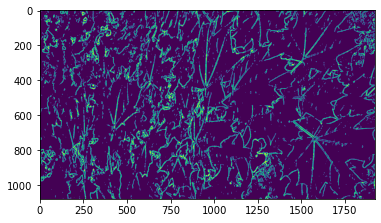

In [32]:
plt.imshow(bw_edge)

In [34]:
bw_edge[20,20:30]

array([False, False, False, False, False, False, False, False, False,
       False])

In [4]:
image = plt.imread(path)

In [5]:
image.shape

(1080, 1920, 3)

In [8]:
image = square_image(image)
image.shape

(1080, 1080, 3)

In [9]:
image = resize(image, (224,224,3), anti_aliasing=False)

In [10]:
image.shape

(224, 224, 3)

In [6]:
def square_image(image):
    side1 = image.shape[0] # vertical side
    side2 = image.shape[1] # horizontal side
    if side1 == side2:
        return image
    margin = np.abs((side1-side2)/2)
    if side1 < side2: # landscape -- horiz > vert
        dim1 = 0 
        dim2 = side1 
        dim3 = int(margin) 
        dim4 = int(margin+side1) 
    else:    # portrait -- vert > horiz
        dim3 = 0 
        dim4 = side2 
        dim1 = int(margin) 
        dim2 = int(margin+side2)
    image = image[dim1:dim2,dim3:dim4]
    return image

In [7]:
def color_224_normal(path, tree, overwrite=False):
    # picture file to numpy array
    image = plt.imread(path)
    # create paths to save files to
    c_path = "augmentations/{}/c_{}".format(tree+'_color', path.stem)
    c_rot_path = "augmentations/{}/c_rot_{}".format(tree+'_color', path.stem)
    c_flip_path = "augmentations/{}/c_flip_{}".format(tree+'_color', path.stem)

    # crop to square
    image = square_image(image)
    # resize raw image to reduce pixels, keep 3 channels
    image = resize(image, (224,224,3), anti_aliasing=False)
    c_rotate = rotate(image, 90)  # rotate CW 90 degrees
    c_fliplr = np.fliplr(image) # flip image        

        # save images to specific tree folder in augmentations folder
    for path in [c_path, c_rot_path, c_flip_path]:
        if not os.path.exists(path) or overwrite:
            np.save(c_path, image, allow_pickle=False)
            np.save(c_rot_path, c_rotate, allow_pickle=False)
            np.save(c_flip_path, c_fliplr, allow_pickle=False)


In [41]:
# credit to DataCamp, Naive Bees project for ideas on augmentations

def bw_augment(path, tree, size=(224,224,1), make_edges=False, overwrite=False):
    # picture file to numpy array
    image = plt.imread(path)
    # process images. make 3 for each 1 raw image
    
    # crop to square
    image = square_image(image)

    # resize raw image to reduce pixels, keep 3 channels for now
    image = resize(image, (image.shape[0] // size_fact, image.shape[1] // size_fact, 
            image.shape[2]), anti_aliasing=False)
    
    if make_edges:
        gray = color.rgb2gray(image)
        edges = sobel(gray)
        thresh = threshold_otsu(edges)

        bw_image = edges > thresh            
        bw_rotate = rotate(bw_image, 90).astype(bool)  # if thresholding
        bw_fliplr = np.fliplr(bw_image) # flip image

        strategy='edge'

    else:
        bw_image = color.rgb2gray(image)  
        bw_rotate = rotate(bw_crop, 90)  # rotate CW 90 degrees
        bw_fliplr = np.fliplr(bw_crop) # flip image

        strategy='grayscale'

   # create paths to save files to
    bw_path = "bw_augmentations/{}/bw_{}".format(tree+'_'+strategy, path.stem)
    bw_rot_path = "bw_augmentations/{}/bw_rot_{}".format(tree+'_'+strategy, path.stem)
    bw_flip_path = "bw_augmentations/{}/bw_flip_{}".format(tree+'_'+strategy, path.stem) 

    # save images to specific tree folder in augmentations folder
    np.save(bw_path, bw_image, allow_pickle=False)
    np.save(bw_rot_path, bw_rotate, allow_pickle=False)
    np.save(bw_flip_path, bw_fliplr, allow_pickle=False)


In [9]:
process_images = True
limit = np.inf
folders = os.listdir('raw_frames')
if process_images: # stop if processing is unnecessary
    # loop through raw images, augment images 3 times, save in new directories
    for t in range(len(folders)):
        count = 0
        path = 'raw_frames/'+folders[t]
        photos = os.listdir(path)   # make list of image files in each tree directory
        for photo in photos:      # loop through each photo, making augmentations
            if count == limit:
                break
            #bw_augment(Path(path +'/'+ photo), folders[t])
            color_224_normal(Path(path +'/'+ photo), folders[t], overwrite=False)
            count += 1
            if count%250 == 0:
                print(count)

250
500
750
1000
1250
1500
250
500
750


In [17]:
path

'raw_frames/maple/maple_1_0000000860.jpg'

In [25]:
color_224_normal(Path(path),'maple')

In [10]:
folders = os.listdir('augmentations')
folders

['maple_color', 'oak_color']

In [12]:
path = 'augmentations/'+folders[0]+'/'+ 'c_maple_1_0000000860.npy'
path
image = np.load(path, allow_pickle=False)

In [13]:
path2 = 'augmentations/'+folders[0]+'/'+ 'c_rot_maple_1_0000000860.npy'

In [14]:
os.path.exists(path2)
image = np.load(path2, allow_pickle=False)

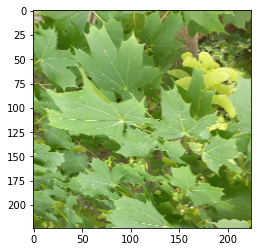

In [15]:
plt.imshow(image)

In [5]:
#from sklearn.preprocessing import StandardScaler

In [23]:
num_samples = 100
chunk_size = 10
chunk_num = num_samples//chunk_size
chunk_num

10

In [31]:
chunk_list = list(range(chunk_num))


In [32]:
for i in range(chunk_num):
    print(chunk_list.pop(0))

0
1
2
3
4
5
6
7
8
9


In [33]:
chunk_num = num_samples*len(folders)//chunk_size

In [34]:
chunk_num

20

In [54]:
#folders = os.listdir('bw_augmentations') # folders with bw numpy images
folders = ['maple_color','oak_color']
num_samples = 2900
chunk_size = 580
chunk_num = num_samples*len(folders)//chunk_size
chunk_list = list(range(chunk_num))
rng = np.random.default_rng()

start = True
X = None
y = None
# make array of random non-repeating numbers
for t in range(len(folders)):
    total_i = []
    if 'maple' in folders[t]:
        tree = 'maple'
        label = 1
        
    else:
        tree = 'oak'
        label = 0
    np_dir = 'augmentations/'+folders[t]
    images = os.listdir(np_dir)
    high = len(images)
    rand_array = rng.permutation(high)[0:num_samples] # non-repeating random integers
    count = 0
    for i in rand_array:
        total_i.append(i)
        file = images[i] # random selection of image from folder
        path = np_dir + '/' + file
        array_i = np.load(path, allow_pickle=False) # take numpy array files from bw_augmentations
    
        
        if start:
            y = np.array([label])
            X = np.array([array_i])
            start=False
            count += 1
        else:
            y = np.append(y,[label]) # for every file from maple or oak add 1 or 0 to y labels
            X = np.append(X,[array_i], axis=0) # add to X - numpy array of images in one file
            count += 1
        if count == chunk_size:
            print(X.shape, y.shape)
            print(count)
            chunk = chunk_list.pop(0)
            np.save('X'+str(chunk)+'_color', X, allow_pickle=False)
            np.save('y'+str(chunk)+'_color', y, allow_pickle=False)
            start = True
            X = None
            y = None
            count = 0
    print(len(set(total_i)))

(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
2900
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
(580, 224, 224, 3) (580,)
580
2900


In [19]:
X.shape, y.shape

((500, 224, 224, 3), (500,))

In [24]:
np.save('X_color', X, allow_pickle=False)
np.save('y_color', y, allow_pickle=False)

In [51]:
# import images as numpy array = X
X = np.load('X6_color.npy', allow_pickle=False)
# import labels as numpy vector = y
y = np.load('y6_color.npy', allow_pickle=False)
# oak = 0; maple = 1

In [52]:
X.shape, y.shape

((10, 224, 224, 3), (10,))

## 1.6 Display Example Images<a id='1.6_examples'></a>

In [ ]:
# augment one image as above for example

path = 'raw_frames\oak\oak_1_0000000250.jpg'

img = Image.open(path)
bw = img.crop((5,5,1085,1085)).convert(mode='L') # crop to square and make black and white
bw_rot = bw.rotate(90) # rotate 90
bw_flip = bw.transpose(method=Image.FLIP_LEFT_RIGHT) # flip image

In [ ]:
# examples of images
display(img) # raw color image
display(bw)  # black and white and cropped to a square
display(bw_rot) # same as above and rotated 90
display(bw_flip) # same as above except flipped left to right


In [ ]:
bw_crop.shape

In [ ]:
show_image(bw_crop)
show_image(bw_fliplr)
show_image(bw_rotate)

In [ ]:
path1 = 'augmentations\\maple_final\\bw_flip_maple_1_0000000010.jpg'
path2 = 'augmentations\\maple_final\\bw_flip_maple_1_0000001250.jpg'
path3 = 'augmentations\\maple_final\\bw_flip_maple_1_0000002500.jpg'

img = Image.open(path1)
display(img)

In [ ]:
image1 = plt.imread(path1)
image2 = plt.imread(path2)
image3 = plt.imread(path3)



In [ ]:
threshes = []
for image in [image1, image2, image3]:
    threshes.append(threshold_otsu(image))
threshes
image_bw = img_np>thresh

In [11]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
show_image(image_bw)

In [ ]:
image_bw.shape

In [ ]:
# credit to DataCamp, Naive Bees project for ideas on augmentations

def process_image(path, tree, overwrite=False):
    img = Image.open(path)
    # create paths to save files to
    bw_path = "augmentations/{}/bw_{}.jpg".format(tree+'_final', path.stem)
    bw_rot_path = "augmentations/{}/bw_rot_{}.jpg".format(tree+'_final', path.stem)
    bw_flip_path = "augmentations/{}/bw_flip_{}.jpg".format(tree+'_final', path.stem)
    
    if not os.path.exists(bw_path) or overwrite:       
        # process images. make 3 for each 1 raw image

        bw = img.crop((5,5,1085,1085)).convert(mode='L') # crop to square and make black and white
        bw_rot = bw.rotate(90) # rotate 90
        bw_flip = bw.transpose(method=Image.FLIP_LEFT_RIGHT) # flip image

        # save images to specific tree folder in augmentations folder 
        bw.save(bw_path)
        bw_rot.save(bw_rot_path)
        bw_flip.save(bw_flip_path)


In [ ]:
process_images = False

folders = os.listdir('raw_frames')
if process_images: # stop if processing is unnecessary
    # loop through raw images, augment images 3 times, save in new directories
    for tree in range(len(folders)):
        path = 'raw_frames\\'+folders[tree]
        photos = os.listdir(path)   # make list of image files in each tree directory
        for photo in photos:      # loop through each photo, making augmentations
            process_image(Path(path +'\\'+ photo), folders[tree])
